##### cell 0 : setup_et_paramèteres
Objectif : Importer les bibliothèques nécessaires 

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Circle, Rectangle, Polygon 

##### Cell 1 :Modélisation de l'Environnement
Objectif :Transformer l'espace physique en un problème d'optimisation numérique.Faire un modèle d'environnement 2D de 12m x 12m avec des obstacles statiques de formes variéeset définir les positions de départ (S) et d'arrivée (T).

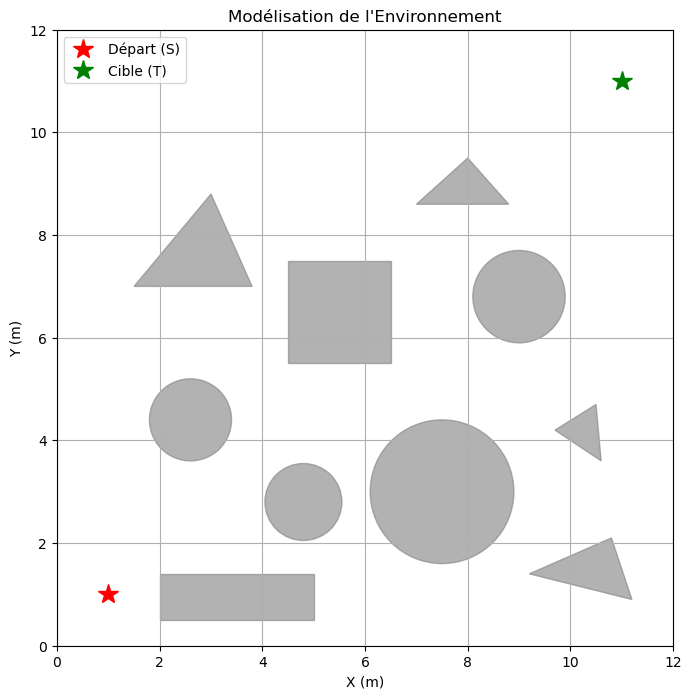

In [37]:
class Environnement:
    """ 
    Modélise l'espace de travail 12m x 12m. Gère les obstacles et la détection stricte de collision.
    """
    def __init__(self, obstacles, start_point, target_point, limites=(0, 12, 0, 12)):
        self.obstacles = obstacles
        self.start_point = np.array(start_point)
        self.target_point = np.array(target_point)
        self.limites = limites

    def _sign(self, p1, p2, p3): 
        """calcule le produit vectoriel 2D,Utilisée pour déterminer de quel côté d'une ligne se trouve un point."""
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    def _point_in_triangle(self, pt, v1, v2, v3):
        """ 
        Algorithme de vérification Barycentrique : vérifie si le point 'pt' est 
        à l'intérieur du triangle formé par les sommets v1, v2 et v3.
        """
        d1 = self._sign(pt, v1, v2)
        d2 = self._sign(pt, v2, v3)
        d3 = self._sign(pt, v3, v1)
  # Un point est dans le triangle s'il est du même côté de toutes les arêtes
        return not ((d1 < 0 or d2 < 0 or d3 < 0) and (d1 > 0 or d2 > 0 or d3 > 0)) 
 
    def est_en_collision(self, point):    #détection de collision 
        """ Vérifie si un point (x, y) est strictement à l'intérieur d'un obstacle. """
        x, y = point
        for obs in self.obstacles:
            if obs['type'] == 'cercle':
                if np.linalg.norm(point - np.array(obs['centre'])) <= obs['rayon']:
                    return True
            elif obs['type'] == 'rectangle':
                xmin, ymin = obs['ancre']
                xmax, ymax = xmin + obs['largeur'], ymin + obs['hauteur']
                if xmin <= x <= xmax and ymin <= y <= ymax:
                    return True
            elif obs['type'] == 'triangle':
                s = obs['sommets']
                if self._point_in_triangle(point, s[0], s[1], s[2]):
                    return True
        return False

    def afficher_carte(self):
        """ Affiche visuellement l'environnement. """
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(self.limites[0], self.limites[1])    # Définition des limites de la zone de travail
        ax.set_ylim(self.limites[2], self.limites[3])
        ax.set_aspect('equal')

        # Dessin des obstacles
        for obs in self.obstacles:
            if obs['type'] == 'cercle':
                ax.add_patch(Circle(obs['centre'], obs['rayon'], color='gray', alpha=0.6))
            elif obs['type'] == 'rectangle':
                ax.add_patch(Rectangle(obs['ancre'], obs['largeur'], obs['hauteur'], color='gray', alpha=0.6))
            elif obs['type'] == 'triangle':
                ax.add_patch(Polygon(obs['sommets'], closed=True, color='gray', alpha=0.6))

        #  Dessin des points de Départ S et d'Arrivée T
        ax.plot(self.start_point[0], self.start_point[1], 'r*', markersize=15, label='Départ (S)')
        ax.plot(self.target_point[0], self.target_point[1], 'g*', markersize=15, label='Cible (T)')
        
        ax.set_title("Modélisation de l'Environnement")
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.legend()
        ax.grid(True)
        plt.show()
# --- CONFIGURATION INITIALE ---
liste_obstacles_12x12 = [
    {'type': 'triangle','sommets': [(1.5, 7.0), (3.0, 8.8), (3.8, 7.0)]},
    {'type': 'triangle','sommets': [(7.0, 8.6), (8.0, 9.5), (8.8, 8.6)]},
    {'type': 'rectangle', 'ancre': (4.5, 5.5), 'largeur': 2,'hauteur': 2},
    {'type': 'cercle',   'centre': (9, 6.8), 'rayon': 0.9},
    {'type': 'cercle',   'centre': (2.6, 4.4), 'rayon': 0.8},
    {'type': 'triangle', 'sommets': [(9.7, 4.2), (10.5, 4.7), (10.6, 3.6)]},
    {'type': 'cercle',   'centre': (4.8, 2.8), 'rayon': 0.75},
    {'type': 'cercle',   'centre': (7.5, 3.0), 'rayon': 1.4},
    {'type': 'rectangle','ancre': (2, 0.5),   'largeur': 3.0,'hauteur': 0.9},
    {'type': 'triangle', 'sommets': [(9.2, 1.4), (10.8, 2.1), (11.2, 0.9)]},   ]
POINT_DEPART = (1, 1)
POINT_CIBLE = (11, 11)
mon_env = Environnement(liste_obstacles_12x12, POINT_DEPART, POINT_CIBLE)
mon_env.afficher_carte()

##### Cell 2 : Modélisation de la Trajectoire et Transformation d'Espace
 Objectif : Cette étape implémente le modèle de trajectoire . L'objectif est de réduire la complexité du problème : au lieu de chercher des coordonnées (x, y) n'importe où sur la carte, l'algorithme cherche uniquement des déviations perpendiculaires (y') le long du segment reliant le départ à la cible.
 ###### Principes Mathématiques
* **Discrétisation du chemin** : La distance totale entre le départ $S$ et la cible $T$ est divisée en $D+1$ segments égaux, créant ainsi $D$ points de passage intermédiaires (waypoints).
* **Repère Local ($S-X'Y'$)** : L'axe $X'$ représente la ligne droite vers la cible, et l'axe $Y'$ représente les déviations latérales possibles que la particule doit optimiser
* **Transformation de Coordonnées** : Pour pouvoir évaluer les collisions et la distance sur la carte réelle (repère global), nous appliquons une transformation géométrique composée :
    1.  **Rotation** : Basée sur l'angle $\theta$ du vecteur $\vec{ST}$ pour aligner le chemin.
    2.  **Translation** : Pour repositionner le chemin par rapport au point de départ réel du robot.
* **Vecteur de la Particule** : Une particule dans ce modèle est définie par $X_i = [y'_1, y'_2, ..., y'_D]$, où chaque $y'_d$ est la position sur la ligne de recherche $L_d$ perpendiculaire à l'axe $ST$.

In [38]:
class TrajectoireModel:
    """Transformation Repère Local (SLPSO)"""
    def __init__(self, start, target, D):
        self.start, self.target = np.array(start), np.array(target)
        self.D = D # nombre points de passage
        vec_st = self.target - self.start  # Calcul du vecteur ST, distance et angle
        self.dist_st = np.linalg.norm(vec_st)
        theta = np.arctan2(vec_st[1], vec_st[0]) # Calcul de l'angle theta pour aligner l'axe X' local sur le segment ST
        c, s = np.cos(theta), np.sin(theta)   
        self.R = np.array([[c, -s], [s, c]]) # Matrice de rotation

    def local_to_global(self, y_primes):
        """Transforme les déviations y' en coordonnées (X, Y) globales."""
        # Création des x' locaux (répartis uniformément entre S et T)
        x_locals = np.linspace(0, self.dist_st, self.D + 2)[1:-1] 
        vec_locals = np.vstack((x_locals, y_primes)) # Regroupement des coordonnées locales (X', Y')
        # Rotation et translation vectorisées
        points_intermediaires = (self.R @ vec_locals).T + self.start
        # Concaténation [S, points, T]
        return np.vstack([self.start, points_intermediaires, self.target]) 
        
    def visualiser_lignes_de_recherche(self, ax, limites_y=(-5, 5)):
        """Affiche les axes de recherche perpendiculaires L1...LD."""
        x_locals = np.linspace(0, self.dist_st, self.D + 2)[1:-1]
        for i, x in enumerate(x_locals):
            # Points haut/bas en local transformés en global
            pts = (self.R @ np.array([[x, x], [limites_y[0], limites_y[1]]])).T + self.start
            ax.plot(pts[:, 0], pts[:, 1], 'b--', alpha=0.3, lw=1)
            ax.text(pts[1, 0], pts[1, 1], f"L{i+1}", fontsize=8, color='blue')

##### Cell 3 : Évaluation Multi-Objectif (Fonction Fitness)
 Objectif : implémente l'évaluateur de performance qui permet de juger la qualité d'un chemin, nous cherchons à minimiser une fonction de coût globale
 Les trois critères clés de coût global du chemin (la fonction J):\
*Distance* : Somme des distances euclidiennes entre les waypoints.\
*Risque de collision* : Calcul du potentiel Gaussien autour de chaque obstacle.\
*Lissage* : Calcul de la somme des angles de dérivation entre trois points successifs . 

In [39]:
# ---outil géométrique pour calculer la distance  entre le point et les obstacles (utile pour calculer le risque )
def _dist_point_segment(p, a, b):
    ap = p - a
    ab = b - a
    t = np.dot(ap, ab) / (np.dot(ab, ab) + 1e-12)
    t = np.clip(t, 0.0, 1.0) #clippé entre 0 et 1 pour rester sur le segment
    proj = a + t * ab
    return np.linalg.norm(p - proj)

def _dist_point_rect(p, ancre, w, h):
    "Calcule la distance entre le point et le bord de rectangle "
    x, y = p
    ax, ay = ancre
    # Calcul de la distance externe par rapport aux bords (0 si le point est aligné avec le rectangle)
    dx = max(ax - x, 0.0, x - (ax + w))
    dy = max(ay - y, 0.0, y - (ay + h))
    return np.hypot(dx, dy)

def _dist_point_triangle(p, sommets): 
    "Calcule la distance entre le point et les sommets de triangle "
    tri = np.array(sommets, dtype=float)
    # Vérifie si le point est strictement à l'intérieur(collision)
    if Path(tri).contains_point(p):
        return 0.0  # si le point est a l'intérieur 
    #Calcul de la distance la plus courte parmi les 3 segments du triangle
    d0 = _dist_point_segment(p, tri[0], tri[1])
    d1 = _dist_point_segment(p, tri[1], tri[2])
    d2 = _dist_point_segment(p, tri[2], tri[0])
    return min(d0, d1, d2)

# --- Classe d'évaluation ---
class EvaluateurChemin:
    def __init__(self, environnement, w1=0.6, w2=0.3, w3=0.1): # poids w1: Longueur, w2: Risque, w3: Douceur
        self.env = environnement
        self.w1, self.w2, self.w3 = w1, w2, w3
        self.R_rob = 0.4        # Rayon du robot
        self.max_influence = 1.2 # Distance au-delà de laquelle le risque est nul
        self.sigma_sq = 1.0     # Paramètre de forme du risque 

    def calculer_longueur(self, points):
        dist_segments = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        return np.sum(dist_segments)

    def calculer_douceur(self, points):
        smoothness = 0.0
        for i in range(1, len(points) - 1):
            vec1 = points[i] - points[i-1]
            vec2 = points[i+1] - points[i]
            norm1 = np.linalg.norm(vec1)
            norm2 = np.linalg.norm(vec2)
            if norm1 > 1e-6 and norm2 > 1e-6:
                cos_angle = np.dot(vec1, vec2) / (norm1 * norm2)
                angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
                smoothness += angle
        return smoothness

    def calculer_risque(self, points, n_samples=10):
        risque_total = 0.0
        nb_points_total = 0

        # Discrétisation des segments pour vérifier les collisions partout
        for i in range(len(points) - 1): 
            a, b = points[i], points[i + 1]
            for t in np.linspace(0.0, 1.0, n_samples): #vérifier les collisions entre les waypoints
                p = (1.0 - t) * a + t * b
                
                # Calculer la distance minimale à l'obstacle le plus proche 
                dmin = float("inf")
                for obs in self.env.obstacles:
                    if obs["type"] == "cercle":
                        d = np.linalg.norm(p - np.array(obs["centre"])) - obs["rayon"]
                    elif obs["type"] == "rectangle":
                        d = _dist_point_rect(p, obs["ancre"], obs["largeur"], obs["hauteur"])
                    elif obs["type"] == "triangle":
                        d = _dist_point_triangle(p, obs["sommets"])
                    dmin = min(dmin, d)

                # Distance de sécurité tenant compte du rayon du robot
                d_safe = dmin - self.R_rob

                if d_safe <= 0:  # Cas 1 : Collision détectée  
                    return float("inf")
                
                if d_safe < self.max_influence: # cas 2 : si robot est proche de obstacle , le risque augmente ( calculer par fonction gaussienne)
                    risque_total += np.exp(-(d_safe**2) / (2 * self.sigma_sq))
                nb_points_total += 1
        
        return risque_total / nb_points_total if nb_points_total > 0 else 0.0 # Retourne le risque moyen sur l'ensemble de la trajectoire

    def evaluer(self, points):
        """  Fonction objectif globale J  """
        R = self.calculer_risque(points) #Évaluation de risque 
        if R == float('inf'):
            return 1e9 # Coût très élevé pour les collisions (pénalité)
        L = self.calculer_longueur(points) #Évaluation de longueur
        S = self.calculer_douceur(points) #Évaluation de douceur 
        return (self.w1 * L) + (self.w2 * R) + (self.w3 * S)

### Développement de l'Algorithme SLPSO

##### Cell 4 : Structure de la Particule (Agent SLPSO)
 Objectif : 
Cette cellule définit l'agent intelligent de notre essaim : la Particule ,Contrairement au PSO classique, nous implémentons ici la structure nécessaire au Self-Learning PSO (SLPSO), où chaque particule est capable d'évaluer l'efficacité de sa propre stratégie de mouvement. 

###### Caractéristiques de la Particule : 
Chaque particule stocke les informations suivantes, essentielles pour l'optimisation de la trajectoire : vecteur de position,de vitesse,mémoire Individuelle(Stocke la meilleure position trouvée) et Apprentissage par Renforcement (SL) :
 selection_ratios ( Probabilités dynamiques de choisir l'un des 4 opérateurs de mouvement.) et 
 progress_values (Enregistre le gain de performance réalisé par chaque stratégie )

In [40]:
class Particle:
    def __init__(self, D, limites_y=(-5.0, 5.0), init_v_random=True):
        """
        D :nombre de waypoints internes, limites_y : bornes de recherche pour y' (local)
        init_v_random : si True, vitesse initiale uniforme dans [-Vmax, Vmax]
        """
        y_min, y_max = float(limites_y[0]), float(limites_y[1])
        self.D = D
        self.limites_y = (y_min, y_max)

        # --- Paramètres PSO classiques ---
        self.position = np.random.uniform(y_min, y_max, D) # Position  initiale des points de passage y' 
        v_max = 0.5 * (y_max - y_min) # calculer la vitesse max autoriséé 
        if init_v_random:           # initialisation de la Vitesse
            self.velocity = np.random.uniform(-v_max, v_max, D)
        else:
            self.velocity = np.zeros(D)

        # # Mémoire individuelle Pbest
        self.pbest_pos = self.position.copy()
        self.pbest_cost = float("inf")
        self.last_cost = None # mesurer coût à l'itération précédente

        # --- Paramètres SLPSO (auto-adaptation) ---
        self.selection_ratios = np.array([0.25, 0.25, 0.25, 0.25], dtype=float) # sélection Ratios (l'un des 4 opérateurs de mouvement) initialisés
        # Compteurs / stats sur une fenêtre Uf 
        self.success_count = np.zeros(4, dtype=int)    # l(t) : nb d'améliorations
        self.total_selected = np.zeros(4, dtype=int)   # L(t) : nb de sélections
        self.progress_values = np.zeros(4, dtype=float)  # progrès cumulés (Eq.15) 
        self.current_operator = 0

#### Cell 5 Algorithme SLPSO (Self-Learning Particle Swarm Optimization)

##### Objectif
Cette cellule regroupe l'intégralité de la logique de recherche et d'optimisation. L'algorithme **SLPSO** est une variante avancée du PSO classique qui permet au robot de ne pas rester bloqué dans des obstacles locaux grâce à un mécanisme d'apprentissage par renforcement.

##### Structure et Fonctionnement
L'implémentation est divisée en quatre piliers logiques conformément à l'article de Li et Chou :

1. Les Opérateurs de Mouvement  : 
   Chaque particule choisit dynamiquement entre quatre stratégies :
   * Exploitation : Affine le chemin actuel.
   * Convergence locale : Suit le voisin le plus proche pour plus de précision.
   * Jumping out : Utilise la vitesse moyenne de l'essaim pour "sauter" par-dessus un obstacle.
   * Exploration : Cherche de nouvelles zones libres sur la carte.

2. La Gestion des Violations (Eq. 16 & 17)** : 
   Pour garantir que la trajectoire reste dans l'espace de travail (12m x 12m), nous appliquons une réflexion miroir: si un waypoint sort des limites, il "rebondit" vers l'intérieur de la zone autorisée.

3. Le Mécanisme Auto-adaptatif (Eq. 12 à 15) : 
   C'est l'intelligence de l'algorithme. Toutes les $U_f$ itérations, le robot analyse quels opérateurs ont le mieux réussi (meilleur gain de coût $J$). Il augmente ensuite la probabilité d'utiliser ces stratégies gagnantes.

4. Boucle d'Optimisation : 
   L'essaim évolue sur un nombre défini d'itérations pour faire converger la fonction de Fitness vers le coût minimal (le chemin le plus court, le plus fluide et le plus sûr).

In [52]:
class SLPSO:
    def __init__(
        self,
        environnement,
        modele_trajectoire,
        evaluateur,
        n_particles=30,
        limites_y=(-5.0, 5.0),
        # Paramètres SLPSO usuels (papier)
        omega=0.73,        # w constant 
        eta3=1.496,
        Uf=3,
        s_min=0.01,
        # Choix opérateur : "argmax" (papier) ou "roulette" (probabiliste)
        operator_selection="argmax",
        # Opérateur c : "uniform" (scalaire U[0,1]) ou "gaussian" (N(0,1))
        jump_random="uniform",
        seed=None,
    ):
        """
        environnement : (optionnel), modele_trajectoire : doit fournir .D et local_to_global()
        evaluateur : doit fournir evaluer(points_globaux)
        """
        if seed is not None:
            np.random.seed(seed)

        self.env = environnement
        self.modele = modele_trajectoire
        self.evaluateur = evaluateur
        self.D = modele_trajectoire.D

        self.limites_y = (float(limites_y[0]), float(limites_y[1]))
        self.omega = float(omega)   # w constant
        self.eta3 = float(eta3)
        self.Uf = int(Uf)
        self.s_min = float(s_min)

        if operator_selection not in ("argmax", "roulette"):
            raise ValueError("operator_selection doit être 'argmax' ou 'roulette'.")
        self.operator_selection = operator_selection

        if jump_random not in ("uniform", "gaussian"):
            raise ValueError("jump_random doit être 'uniform' ou 'gaussian'.")
        self.jump_random = jump_random

        # Essaim
        self.swarm = [Particle(self.D, limites_y=self.limites_y, init_v_random=True)
                      for _ in range(n_particles)]
        # Gbest
        self.gbest_pos = np.zeros(self.D)
        self.gbest_cost = float("inf")
        self.history = []
    # ============================================================
    # 3.2.3 Gestion des violations de frontières (Eq.16 - Eq.17)
    # ============================================================
    def gerer_limites(self, p: Particle):
        """
        Eq.(16) : limiter la vitesse dans [-Vmax, Vmax]
        Eq.(17) : réflexion de la position si hors bornes, puis clamp de sécurité
        """
        l, u = p.limites_y
        v_max = 0.5 * (u - l)  # Vmax = moitié du domaine (Eq.16)
        # Eq.16 : clamp vitesse
        p.velocity = np.clip(p.velocity, -v_max, v_max)
        # Eq.17 : réflexion position
        x = p.position
        x = np.where(x > u, 2.0 * u - x, x)
        x = np.where(x < l, 2.0 * l - x, x)

        # clamp final de sécurité
        p.position = np.clip(x, l, u)
    # ============================================================
    # 3.2.1 Implémentation des 4 stratégies (a, b, c, d)
    # ============================================================
    def appliquer_strategies(self, p: Particle, idx: int, v_moyenne: np.ndarray):
        """
        Applique l'un des 4 opérateurs SLPSO (Section 3.2.1).
        - a) exploitation (Pbest)
        - b) convergence (Pbest du voisin le plus proche)
        - c) jumping out (perturbation via V_average^k)
        - d) exploration (Gbest)
        """
        r = np.random.rand(self.D)
        op = p.current_operator
        eta3 = self.eta3
        w = self.omega  # constant

        # --- a : Exploitation (Pbest)
        if op == 0:
            p.velocity = w * p.velocity + eta3 * r * (p.pbest_pos - p.position)
            p.position = p.position + p.velocity
            
        # --- b : Convergence (Pbest du voisin le plus proche)
        elif op == 1:
            p_near = self._trouver_pbest_voisin_proche(idx)  # vecteur pbest_pos du voisin
            p.velocity = w * p.velocity + eta3 * r * (p_near - p.position)
            p.position = p.position + p.velocity
            
        # --- c : Jumping out (sortie d'optimum local)
        elif op == 2:
            # Deux versions possibles suivant l'interprétation du papier :
            if self.jump_random == "uniform":
                # scalaire U[0,1]
                rnd = np.random.rand()
            else:
                # scalaire N(0,1)
                rnd = np.random.normal(0.0, 1.0)

            p.position = p.position + v_moyenne * rnd
            # (souvent, on ne modifie pas la vitesse ici)

        # --- d : Exploration (Gbest)
        elif op == 3:
            p.velocity = w * p.velocity + eta3 * r * (self.gbest_pos - p.position)
            p.position = p.position + p.velocity

        else:
            raise ValueError(f"Opérateur inconnu: {op}")
    # ====================================================
    # 3.2.2 Mécanisme auto-adaptatif (Eq.12 - Eq.15)
    # =====================================================
    def mettre_a_jour_ratios(self, p: Particle):
        """
        Mise à jour des ratios de sélection des 4 opérateurs.
        - Eq.(12) : update de s(t) avec s_min
        - Eq.(13) : reward = beta*pr + (1-beta)*succ + c*s
        - Eq.(14) : pénalité c(t)=0.9 si (t = argmax(s)) et aucun succès
        - Eq.(15) : pr (progress) alimenté dans optimiser() à partir des coûts
        """
        beta = np.random.rand()  # [0,1]
        s_min = self.s_min

        rewards = np.zeros(4, dtype=float)

        # opérateur au ratio max (utilisé pour la pénalité Eq.14)
        t_best = int(np.argmax(p.selection_ratios))

        # somme des progrès (pour normaliser)
        pr_sum = float(np.sum(p.progress_values))

        for t in range(4):
            # terme progrès (Eq.13 + Eq.15)
            term_pr = (p.progress_values[t] / pr_sum) * beta if pr_sum > 0 else 0.0

            # terme succès (Eq.13) : l/L
            L = float(p.total_selected[t])
            term_succ = (p.success_count[t] / L) * (1.0 - beta) if L > 0 else 0.0

            # pénalité Eq.14 + terme c*s dans Eq.13
            c = 0.9 if (t == t_best and p.success_count[t] == 0) else 1.0
            term_cs = c * p.selection_ratios[t]

            rewards[t] = term_pr + term_succ + term_cs

        s = float(np.sum(rewards))
        if s <= 0:
            # fallback sûr
            p.selection_ratios[:] = 0.25
        else:
            # Eq.(12)
            p.selection_ratios = (rewards / s) * (1.0 - 4.0 * s_min) + s_min

        # reset stats pour la prochaine fenêtre Uf
        p.progress_values.fill(0.0)
        p.success_count.fill(0)
        p.total_selected.fill(0)
    # ============================================================
    # Choix d'opérateur (argmax ou roulette)
    # ============================================================
    def choisir_operateur(self, p: Particle) -> int:
        """
        - argmax : choisit l'opérateur au ratio max (souvent le plus proche du papier)
        - roulette : tirage probabiliste selon selection_ratios
        """
        if self.operator_selection == "argmax":
            return int(np.argmax(p.selection_ratios))
        return int(np.random.choice(4, p=p.selection_ratios))
    # ============================================================
    # Optimisation (itérations commencent à 1 comme demandé)
    # ============================================================
    def optimiser(self, max_iter=150, afficher_tous=10):
        """
        Boucle principale SLPSO.
        - k démarre à 1
        - V_average^k calculée une fois au début de chaque itération k
        - progress (Eq.15) et success_count alimentés sur fenêtre Uf
        - update ratios chaque Uf itérations
        """
        # --- Initialisation : évaluer chaque particule -> pbest et gbest ---
        for p in self.swarm:
            pts = self.modele.local_to_global(p.position)
            cost = self.evaluateur.evaluer(pts)

            p.pbest_cost = cost
            p.pbest_pos = p.position.copy()
            p.last_cost = cost

            if cost < self.gbest_cost:
                self.gbest_cost = cost
                self.gbest_pos = p.position.copy()

        # --- Itérations : k = 1..max_iter ---
        for k in range(1, max_iter + 1):
            # V_average^k (moyenne des vitesses avant mises à jour)
            v_moyenne = np.mean([part.velocity for part in self.swarm], axis=0)

            for i, p in enumerate(self.swarm):
                # 1) Choisir opérateur
                op = self.choisir_operateur(p)
                p.current_operator = op
                p.total_selected[op] += 1

                # 2) Sauvegarder coût précédent (pour Eq.15)
                cost_prev = p.last_cost

                # 3) Déplacer la particule (opérateur)
                self.appliquer_strategies(p, i, v_moyenne)

                # 4) Gérer frontières (Eq.16-17)
                self.gerer_limites(p)

                # 5) Évaluer le nouveau coût
                pts = self.modele.local_to_global(p.position)
                cost = self.evaluateur.evaluer(pts)

                # 6) Eq.(15) : si amélioration vs itération précédente -> progrès + succès
                if cost_prev is not None and cost < cost_prev:
                    p.progress_values[op] += abs(cost - cost_prev)
                    p.success_count[op] += 1
                p.last_cost = cost

                # 7) Mise à jour pbest / gbest
                if cost < p.pbest_cost:
                    p.pbest_cost = cost
                    p.pbest_pos = p.position.copy()

                    if cost < self.gbest_cost:
                        self.gbest_cost = cost
                        self.gbest_pos = p.position.copy()

                # 8) Mise à jour des ratios toutes les Uf itérations
                if (k % self.Uf) == 0:
                    self.mettre_a_jour_ratios(p)

            self.history.append(self.gbest_cost)

            # Affichage
            if (k == 1) or (k % afficher_tous == 0):
                print(f"Itération {k} | Meilleur coût: {self.gbest_cost:.2f}")

        return self.gbest_pos, self.gbest_cost
    # ============================================================
    # Utilitaire : voisin le plus proche (pour l'opérateur b)
    # ============================================================
    def _trouver_pbest_voisin_proche(self, idx: int) -> np.ndarray:
        """
        Trouve la particule la plus proche (distance sur position courante),
        puis renvoie son Pbest (vecteur).
        """
        x = self.swarm[idx].position
        distances = [np.linalg.norm(x - p.position) for p in self.swarm]
        distances[idx] = float("inf")
        j = int(np.argmin(distances))
        return self.swarm[j].pbest_pos.copy() 

##### Cell 6 : affichage 
Objectif : afficher de resultats ( trajectoire optimale et l'évolution de cout globale ) 

Démarrage de l'optimisation SLPSO...
Itération 1 | Meilleur coût: 11.09
Itération 10 | Meilleur coût: 11.09
Itération 20 | Meilleur coût: 11.00
Itération 30 | Meilleur coût: 10.84
Itération 40 | Meilleur coût: 10.81
Itération 50 | Meilleur coût: 10.74
Itération 60 | Meilleur coût: 10.72
Itération 70 | Meilleur coût: 10.71
Itération 80 | Meilleur coût: 10.71
Itération 90 | Meilleur coût: 10.70
Itération 100 | Meilleur coût: 10.70
Itération 110 | Meilleur coût: 10.70
Itération 120 | Meilleur coût: 10.69
Itération 130 | Meilleur coût: 10.69
Itération 140 | Meilleur coût: 10.69
Itération 150 | Meilleur coût: 10.69


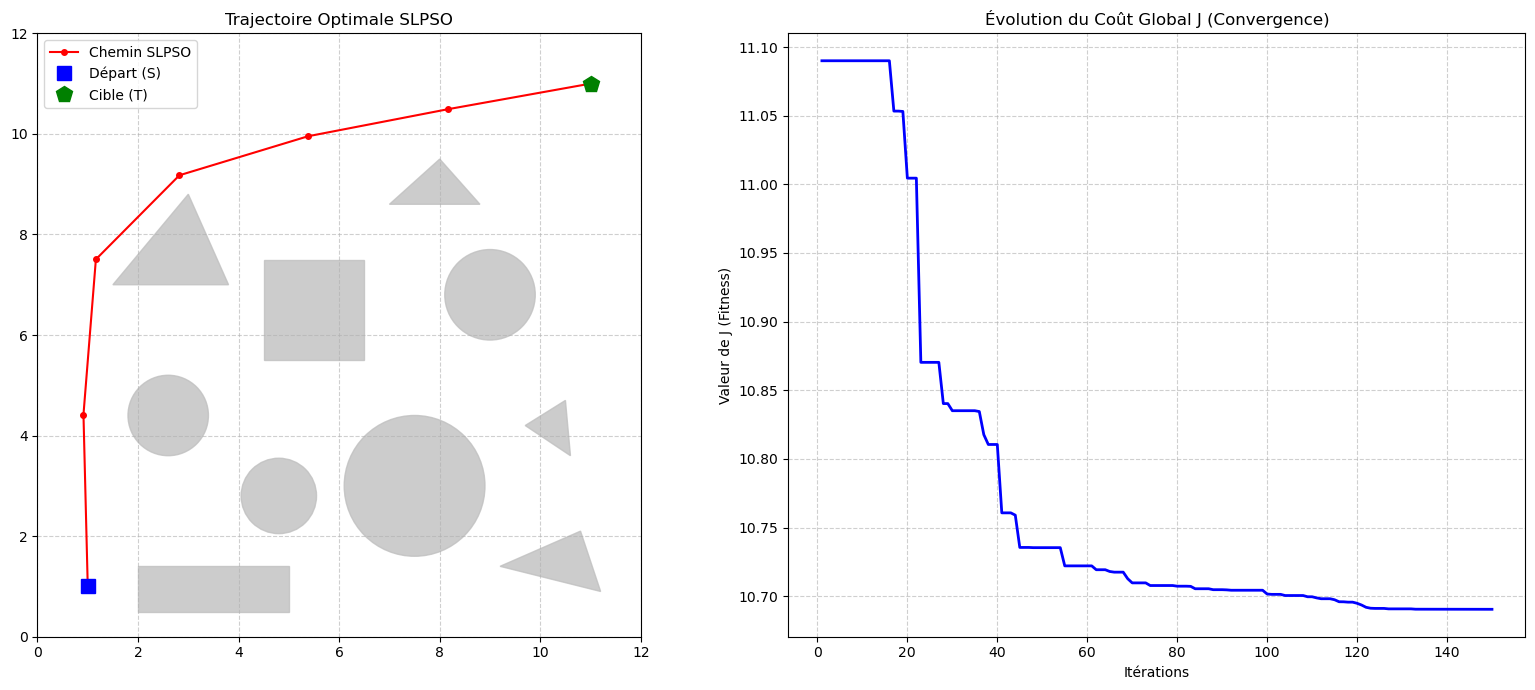


--- Statistiques du meilleur chemin ---
Coût Final J : 10.6905
Longueur totale : 17.26 m
Indice de douceur : 1.42 rad


In [53]:
D_WAYPOINTS = 5
N_PARTICULES = 30
MAX_ITER = 150
import random 
SEED = 42
np.random.seed(SEED)
random.seed(SEED) 
modele = TrajectoireModel(POINT_DEPART, POINT_CIBLE, D_WAYPOINTS)
evaluateur = EvaluateurChemin(mon_env)
algo_slpso = SLPSO(mon_env, modele, evaluateur, n_particles=N_PARTICULES)

# LANCEMENT DE L'ALGORITHME ---
print("Démarrage de l'optimisation SLPSO...")
algo_slpso.optimiser(max_iter=MAX_ITER)

# RÉCUPÉRATION DES RÉSULTATS 
wp = modele.local_to_global(algo_slpso.gbest_pos)  # waypoints internes
chemin_final = np.vstack([POINT_DEPART, wp, POINT_CIBLE])

#  VISUALISATION 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# A. Trajectoire
ax1.set_title("Trajectoire Optimale SLPSO")
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 12)
ax1.set_aspect('equal')

for obs in mon_env.obstacles:
    if obs['type'] == 'cercle':
        ax1.add_patch(plt.Circle(obs['centre'], obs['rayon'], color='silver', alpha=0.8))
    elif obs['type'] == 'rectangle':
        ax1.add_patch(plt.Rectangle(obs['ancre'], obs['largeur'], obs['hauteur'], color='silver', alpha=0.8))
    elif obs['type'] == 'triangle':
        ax1.add_patch(plt.Polygon(obs['sommets'], closed=True, color='silver', alpha=0.8))
        
ax1.plot(chemin_final[:, 0], chemin_final[:, 1], 'r-o', markersize=4, label='Chemin SLPSO')
ax1.plot(POINT_DEPART[0], POINT_DEPART[1], 'bs', markersize=10, label='Départ (S)')
ax1.plot(POINT_CIBLE[0], POINT_CIBLE[1], 'gp', markersize=12, label='Cible (T)')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()
# B. Convergence
ax2.set_title("Évolution du Coût Global J (Convergence)")
iters = np.arange(1, len(algo_slpso.history) + 1)   # itérations 1..N
ax2.plot(iters, algo_slpso.history, color='blue', linewidth=2)
ax2.set_xlabel("Itérations")
ax2.set_ylabel("Valeur de J (Fitness)")
ax2.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(f"\n--- Statistiques du meilleur chemin ---")
print(f"Coût Final J : {algo_slpso.gbest_cost:.4f}")
print(f"Longueur totale : {evaluateur.calculer_longueur(chemin_final):.2f} m")
print(f"Indice de douceur : {evaluateur.calculer_douceur(chemin_final):.2f} rad")

#### Cell 7. Algorithme PSO Standard (Référence de comparaison)

#### objectif 
Pour prouver que l'algorithme **SLPSO** est plus performant, j'ai créé une version classique du PSO. Contrairement au SLPSO, cette version n'a pas d'apprentissage : elle utilise une seule formule de mouvement pour tout le groupe.

#### Caractéristiques :
* **Vitesse classique** : Utilise uniquement le meilleur point personnel ($Pbest$) et le meilleur point du groupe ($Gbest$).
* **Inertie décroissante** : Le robot cherche partout au début et se concentre sur la cible à la fin.
* **Même environnement** : Il utilise les mêmes obstacles et le même modèle de trajectoire pour que la comparaison soit juste.

In [63]:
class PSOStandard:
    def __init__(self, environnement, modele_trajectoire, evaluateur, n_particles=30):
        self.env = environnement
        self.modele = modele_trajectoire
        self.evaluateur = evaluateur
        self.D = modele_trajectoire.D
        # Initialisation : on s'assure que les particules ne sont pas "mortes" dès le départ
        self.swarm = [Particle(self.D, limites_y=(-5.0, 5.0)) for _ in range(n_particles)]
        self.gbest_pos = np.zeros(self.D)
        self.gbest_cost = float('inf')
        self.history = []
        self.c1 = 1.496 # Paramètres standards cités dans la littérature PSO (c1=c2=1.496)
        self.c2 = 1.496 

    def gerer_limites(self, p):
        """ Réflexion aux frontières  """
        l, u = -5.0, 5.0
        v_max = 0.5 * (u - l)
        p.velocity = np.clip(p.velocity, -v_max, v_max)
        # Application de la réflexion miroir pour garder la diversité
        p.position = np.where(p.position > u, 2.0 * u - p.position, p.position)
        p.position = np.where(p.position < l, 2.0 * l - p.position, p.position)
        p.position = np.clip(p.position, l, u)

    def optimiser(self, max_iter=150):
        # 1. Évaluation initiale (Définition du point de départ)
        for p in self.swarm:
            pts = self.modele.local_to_global(p.position)
            p.pbest_cost = self.evaluateur.evaluer(pts)
            p.pbest_pos = p.position.copy() # INDISPENSABLE : copier la valeur
            if p.pbest_cost < self.gbest_cost:
                self.gbest_cost = p.pbest_cost
                self.gbest_pos = p.position.copy()

        # 2. Boucle de recherche
        for k in range(1, max_iter + 1):
            w = 0.9 - (k / max_iter) * 0.5   # Équation 11 : Poids d'inertie décroissant
            
            for p in self.swarm:
                r1, r2 = np.random.rand(self.D), np.random.rand(self.D)
                
                p.velocity = (w * p.velocity +     # Équation classique du PSO (vitesse)
                              self.c1 * r1 * (p.pbest_pos - p.position) +
                              self.c2 * r2 * (self.gbest_pos - p.position))
                
                # Mise à jour de la position
                p.position += p.velocity
                self.gerer_limites(p)
                # Évaluation du coût (Distance + Risque + Douceur)
                pts = self.modele.local_to_global(p.position)
                cout = self.evaluateur.evaluer(pts)
                # Mise à jour des mémoires (Pbest et Gbest)
                if cout < p.pbest_cost:
                    p.pbest_cost = cout
                    p.pbest_pos = p.position.copy() # Toujours utiliser .copy()
                
                if cout < self.gbest_cost:
                    self.gbest_cost = cout
                    self.gbest_pos = p.position.copy()

            self.history.append(self.gbest_cost)
        return self.gbest_pos, self.gbest_cost

### Cell8 :  Résultats et Comparaison des Trajectoires

Lancement SLPSO (Auto-adaptatif)...
Itération 1 | Meilleur coût: 11.09
Itération 10 | Meilleur coût: 11.09
Itération 20 | Meilleur coût: 11.00
Itération 30 | Meilleur coût: 10.84
Itération 40 | Meilleur coût: 10.81
Itération 50 | Meilleur coût: 10.74
Itération 60 | Meilleur coût: 10.72
Itération 70 | Meilleur coût: 10.71
Itération 80 | Meilleur coût: 10.71
Itération 90 | Meilleur coût: 10.70
Itération 100 | Meilleur coût: 10.70
Itération 110 | Meilleur coût: 10.70
Itération 120 | Meilleur coût: 10.69
Itération 130 | Meilleur coût: 10.69
Itération 140 | Meilleur coût: 10.69
Itération 150 | Meilleur coût: 10.69
Lancement PSO Standard...


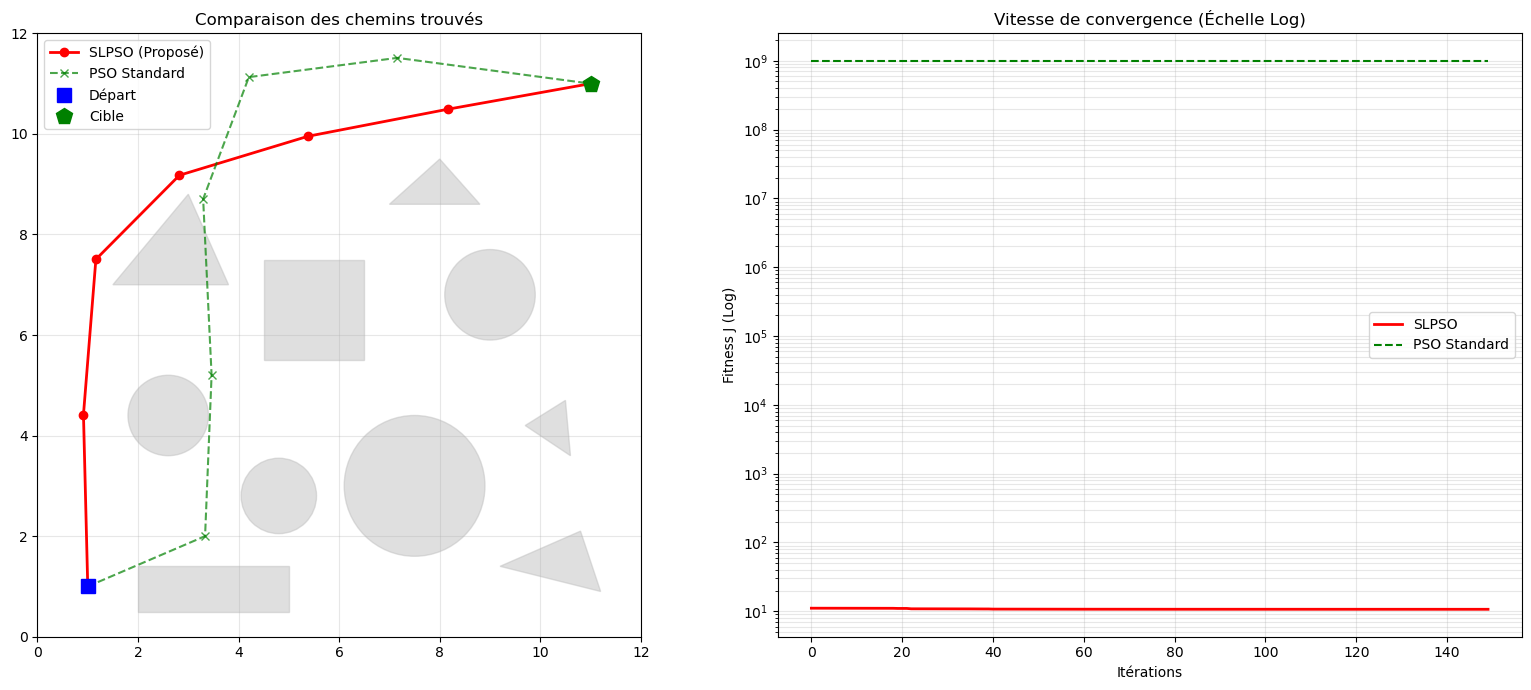

Score Final SLPSO : 10.6905
Score Final PSO Standard : 1000000000.0000


In [62]:
# --- 1. CONFIGURATION ---
D_WAYPOINTS = 5 
N_PARTICULES = 30
MAX_ITER = 150
np.random.seed(42)

# Modèles et environnement
modele = TrajectoireModel(POINT_DEPART, POINT_CIBLE, D_WAYPOINTS)
evaluateur = EvaluateurChemin(mon_env)

# --- 2. LANCEMENT ---
print("Lancement SLPSO (Auto-adaptatif)...")
algo_slpso = SLPSO(mon_env, modele, evaluateur, n_particles=N_PARTICULES)
algo_slpso.optimiser(max_iter=MAX_ITER)

print("Lancement PSO Standard...")
algo_pso_std = PSOStandard(mon_env, modele, evaluateur, n_particles=N_PARTICULES)
algo_pso_std.optimiser(max_iter=MAX_ITER)

# --- 3. RÉCUPÉRER LE CHEMIN FINAL ---
chemin_slpso = modele.local_to_global(algo_slpso.gbest_pos)
chemin_pso_std = modele.local_to_global(algo_pso_std.gbest_pos)

# --- 4. AFFICHAGE DES GRAPHIQUES ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Graphique A : Dessiner les trajectoires sur la carte
ax1.set_title("Comparaison des chemins trouvés")
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 12)
ax1.set_aspect('equal')

# Dessiner les obstacles (cercles, carrés, triangles)
for obs in mon_env.obstacles:
    if obs['type'] == 'cercle':
        ax1.add_patch(plt.Circle(obs['centre'], obs['rayon'], color='silver', alpha=0.5))
    elif obs['type'] == 'rectangle':
        ax1.add_patch(plt.Rectangle(obs['ancre'], obs['largeur'], obs['hauteur'], color='silver', alpha=0.5))
    elif obs['type'] == 'triangle':
        ax1.add_patch(plt.Polygon(obs['sommets'], closed=True, color='silver', alpha=0.5))

# Tracer les lignes des deux chemins pour comparer
ax1.plot(chemin_slpso[:, 0], chemin_slpso[:, 1], 'r-o', linewidth=2, label='SLPSO (Proposé)')
ax1.plot(chemin_pso_std[:, 0], chemin_pso_std[:, 1], 'g--x', alpha=0.7, label='PSO Standard')

# Marquer les points de départ et d'arrivée
ax1.plot(POINT_DEPART[0], POINT_DEPART[1], 'bs', markersize=10, label='Départ')
ax1.plot(POINT_CIBLE[0], POINT_CIBLE[1], 'gp', markersize=12, label='Cible')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique B : Courbe de convergence
ax2.set_title("Vitesse de convergence (Échelle Log)")
ax2.plot(algo_slpso.history, 'r', linewidth=2, label='SLPSO')
ax2.plot(algo_pso_std.history, 'g--', label='PSO Standard')

# Mettre l'échelle en Log pour bien voir la différence de coût
ax2.set_yscale('log') 
ax2.set_xlabel("Itérations")
ax2.set_ylabel("Fitness J (Log)")
ax2.legend()
ax2.grid(True, which="both", alpha=0.3)

plt.tight_layout()
plt.show()

# Afficher les scores finaux dans la console
print(f"Score Final SLPSO : {algo_slpso.gbest_cost:.4f}")
print(f"Score Final PSO Standard : {algo_pso_std.gbest_cost:.4f}")